In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df_clean = df.copy()

Combine Date and Time columns into a single datetime column

In [ ]:
df_clean['DateTime'] = pd.to_datetime(df_clean['Date'] + ' ' + df_clean['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing all suffix

In [ ]:
df_clean['Energy'] = df_clean['Energy'].str.replace('kWh', '').astype(float)
df_clean['Efficiency'] = df_clean['Efficiency'].str.replace('kWh/kW', '').astype(float)
df_clean['Power'] = df_clean['Power'].str.replace('W', '').str.replace(',', '').astype(float)
df_clean['Average'] = pd.to_numeric(df_clean['Average'].str.replace('W', '').str.replace(',', ''), errors='coerce')
df_clean['Normalised'] = pd.to_numeric(df_clean['Normalised'].str.replace('kW/kW', '').str.replace(',', ''), errors='coerce')
df_clean['Temperature'] = df_clean['Temperature'].str.replace('C', '').astype(float)
df_clean['Energy Used'] = df_clean['Energy Used'].str.replace('kWh', '').astype(float)
df_clean['Voltage'] = df_clean['Voltage'].str.replace('V', '').astype(float)
df_clean['Power Used'] = df_clean['Power Used'].str.replace('W', '').str.replace(',', '').astype(float)

In [ ]:
df_clean.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
df_clean.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [ ]:
df_clean.sort_index(inplace=True)

In [ ]:
df_clean = df_clean.resample('30min').last()

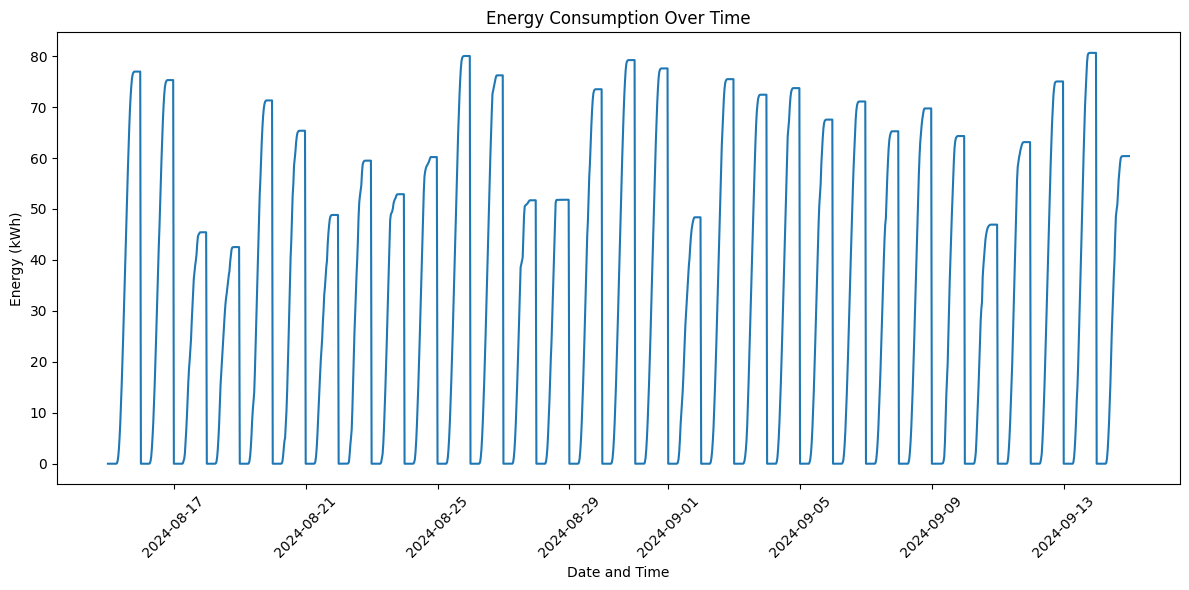

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
df_clean.head()

,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used
DateTime,,,,,,,,,
2024-08-15 00:00:00,0.0,0.0,0.0,0.0,0.0,24.2,229.2,0.099,228.0
2024-08-15 00:30:00,0.0,0.0,0.0,0.0,0.0,23.6,229.3,0.269,624.0
2024-08-15 01:00:00,0.0,0.0,0.0,0.0,0.0,24.2,226.7,0.610,864.0
2024-08-15 01:30:00,0.0,0.0,0.0,0.0,0.0,24.2,230.4,1.158,1128.0
2024-08-15 02:00:00,0.0,0.0,0.0,0.0,0.0,25.3,229.8,1.503,732.0


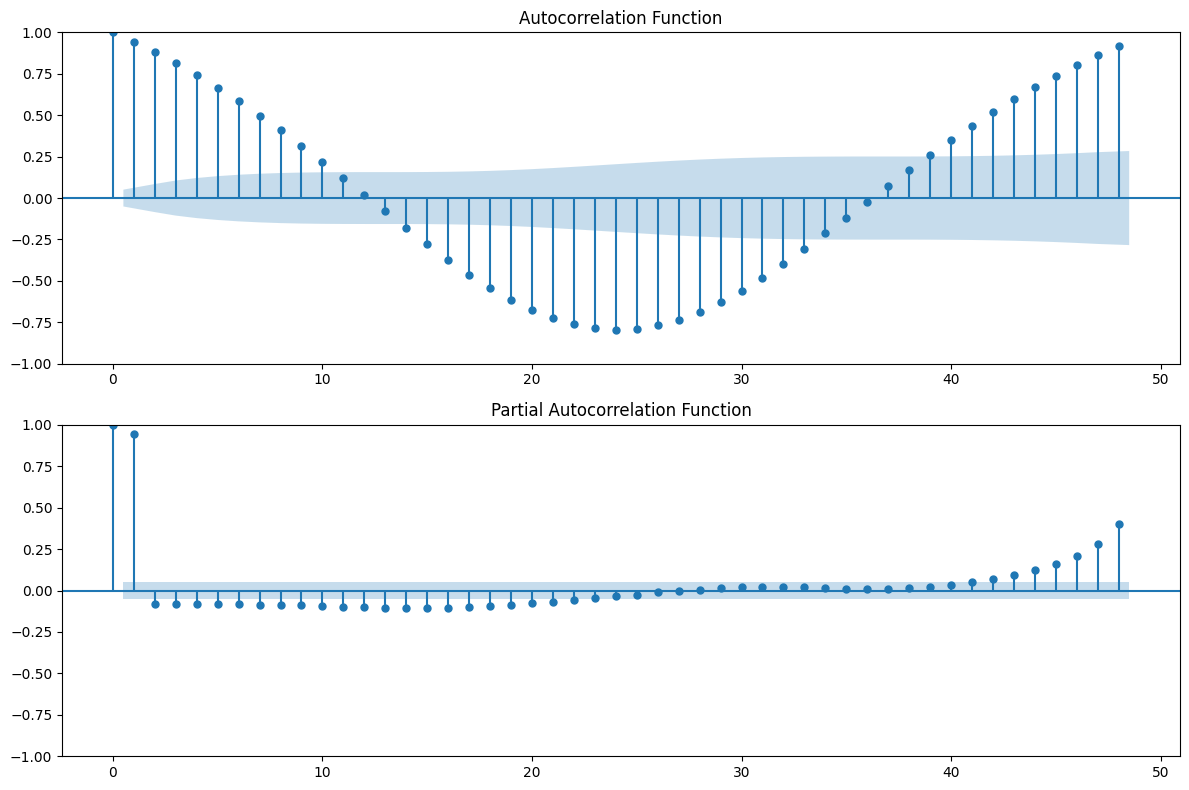

In [ ]:
def analyze_lags(data, max_lags=48):
  # Plot ACF
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

  plot_acf(data, lags=max_lags, ax=ax1)
  ax1.set_title('Autocorrelation Function')

  # Plot PACF
  plot_pacf(data, lags=max_lags, ax=ax2)
  ax2.set_title('Partial Autocorrelation Function')

  plt.tight_layout()
  plt.show()

analyze_lags(df_clean['Energy'])

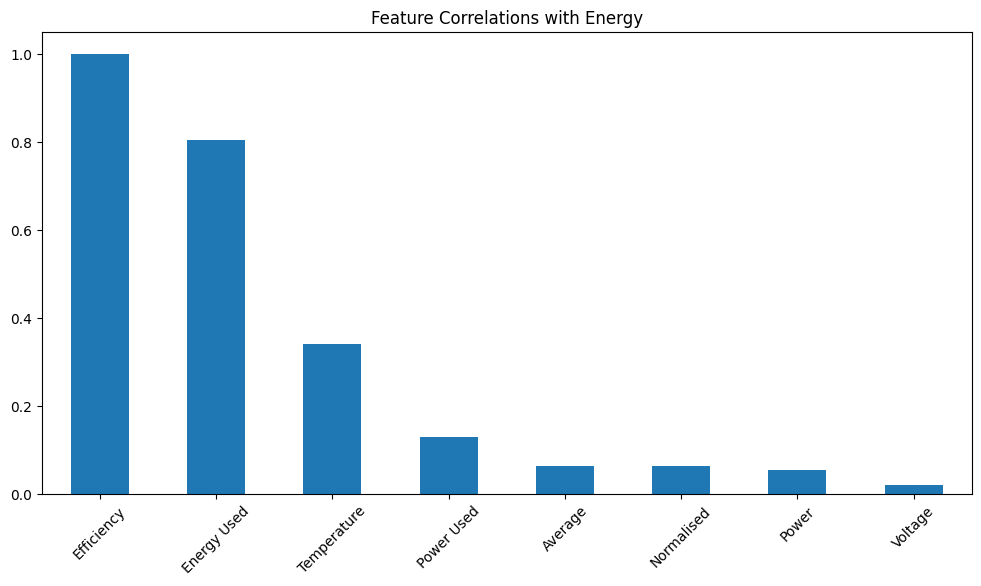

In [ ]:
def feature_relevance(df, target='Energy'):
  correlations = df_clean.corr()[target].sort_values(ascending=False)

  plt.figure(figsize=(12, 6))
  correlations.drop(target).plot(kind='bar')
  plt.title('Feature Correlations with Energy')
  plt.xticks(rotation=45)
  plt.show()

feature_relevance(df_clean)

Looking at your correlation graph,Strong Correlations: Enegy, Energy Used, Temperature.

In [ ]:
features_with_lags = ['Efficiency', 'Energy Used', 'Temperature']
features_without_lags = ['Power', 'Average', 'Normalised', 'Voltage', 'Power Used']

def lags_sequences(df_clean, n_lags=48):
  X = []
  y = []

# Features that need lags
  for i in range(len(df_clean) - n_lags):
      lagged_sequence = []
      for col in features_with_lags:
        var_sequence = df_clean[col].iloc[i:(i + n_lags)].values
        lagged_sequence.append(var_sequence)

  # Add non-Lagged features (just current value)
      current_values = df_clean[features_without_lags].iloc[i + n_lags].values

  # Combined lagged and current features
      X.append({
        'lagged': np.array(lagged_sequence).T,
        'current': current_values
      })

      y.append(df_clean['Energy'].iloc[i + n_lags])

  return X, np.array(y)

X, y = lags_sequences(df_clean, n_lags=48)

print("Length of X:", len(X))
print("Length of y:", len(y))

Length of X: 1440
Length of y: 1440


In [ ]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Scale X (reshape required for scaling)
X_samples = len(X) # The number of different sequences you're using to train the model.
n_lags = X[0]['lagged'].shape[0] # The number of lags you're using
X_features = X[0]['lagged'].shape[1]  # The number of variables you are using at each time point

# Reshape to 2D for scaling
X_reshaped = np.array([x['lagged'] for x in X]).reshape(-1, X_features)
X_scaled = X_scaler.fit_transform(X_reshaped)

# Reshape back to 3D for LSTM
X_scaled = X_scaled.reshape(X_samples, n_lags, X_features)

# Scale y
y = np.array(y).reshape(-1, 1)
y_scaled = y_scaler.fit_transform(y)

print("X_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)

X_scaled shape: (1440, 48, 3)
y_scaled shape: (1440, 1)


Split the data into training and testing sets (80% train, 20% test)

In [ ]:
train_size = int(len(X_scaled) * 0.8)

# Split X
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]

# Split y
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]


print("Training shapes")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nTesting shapes")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Training shapes
X_train shape: (1152, 48, 3)
y_train shape: (1152, 1)

Testing shapes
X_test shape: (288, 48, 3)
y_test shape: (288, 1)


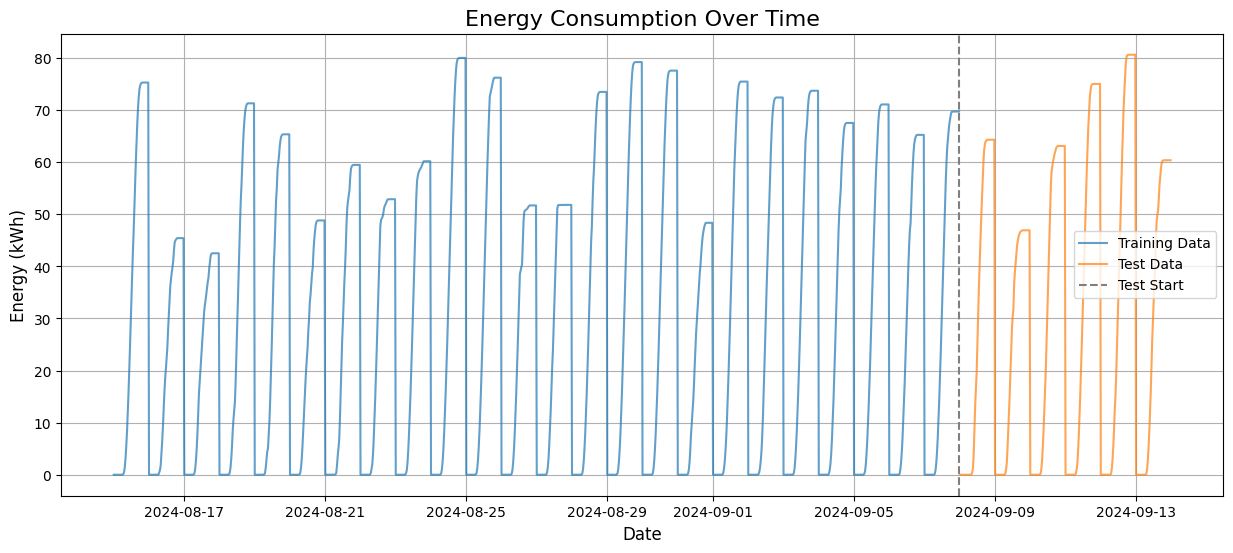

In [ ]:
time_index = pd.date_range(start='15-08-2024', periods=len(y_scaled), freq='30min')

# Split time index
train_index = time_index[:len(y_train)]
test_index = time_index[len(y_train):]

# Inverse transform the scaled values
y_train_orig = y_scaler.inverse_transform(y_train)
y_test_orig = y_scaler.inverse_transform(y_test)

# Time series pot

def plot_energy_over_time(y_train, y_test, time_index, y_scaler):

    plt.figure(figsize=(15, 6))
    plt.plot(train_index, y_train_orig, label='Training Data', alpha=0.7)
    plt.plot(test_index, y_test_orig, label='Test Data', alpha=0.7)
    plt.axvline(x=train_index[-1], color='grey', linestyle='--', label='Test Start')
    plt.title('Energy Consumption Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Energy (kWh)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_energy_over_time(y_train, y_test, time_index, y_scaler)

In [ ]:
def create_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        # First LSTM layer
        LSTM(128, activation='relu',
             return_sequences=True),
        Dropout(0.2),  # Prevent overfitting

        # Second LSTM layer
        LSTM(64, activation='relu'),
        Dropout(0.2),

        # Dense layers
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create callbacks for better training
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# Create and train model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

In [ ]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - loss: 0.1950 - mae: 0.3511 - val_loss: 0.0557 - val_mae: 0.1840
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0479 - mae: 0.1744 - val_loss: 0.0205 - val_mae: 0.0930
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0293 - mae: 0.1164 - val_loss: 0.0149 - val_mae: 0.0759
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0233 - mae: 0.0985 - val_loss: 0.0235 - val_mae: 0.0930
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0219 - mae: 0.0980 - val_loss: 0.0106 - val_mae: 0.0593
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0188 - mae: 0.0877 - val_loss: 0.0114 - val_mae: 0.0618
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0185 - mae: 0.0822 - val_loss: 0.0095 - val_mae: 0.0545
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0178 - mae: 0.0822 - val_loss: 0.0163 - val_mae: 0.0720
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - 

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Since data was scaled, inverse transform predictions and actual values
y_pred_original = y_scaler.inverse_transform(y_pred)
y_test_original = y_scaler.inverse_transform(y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


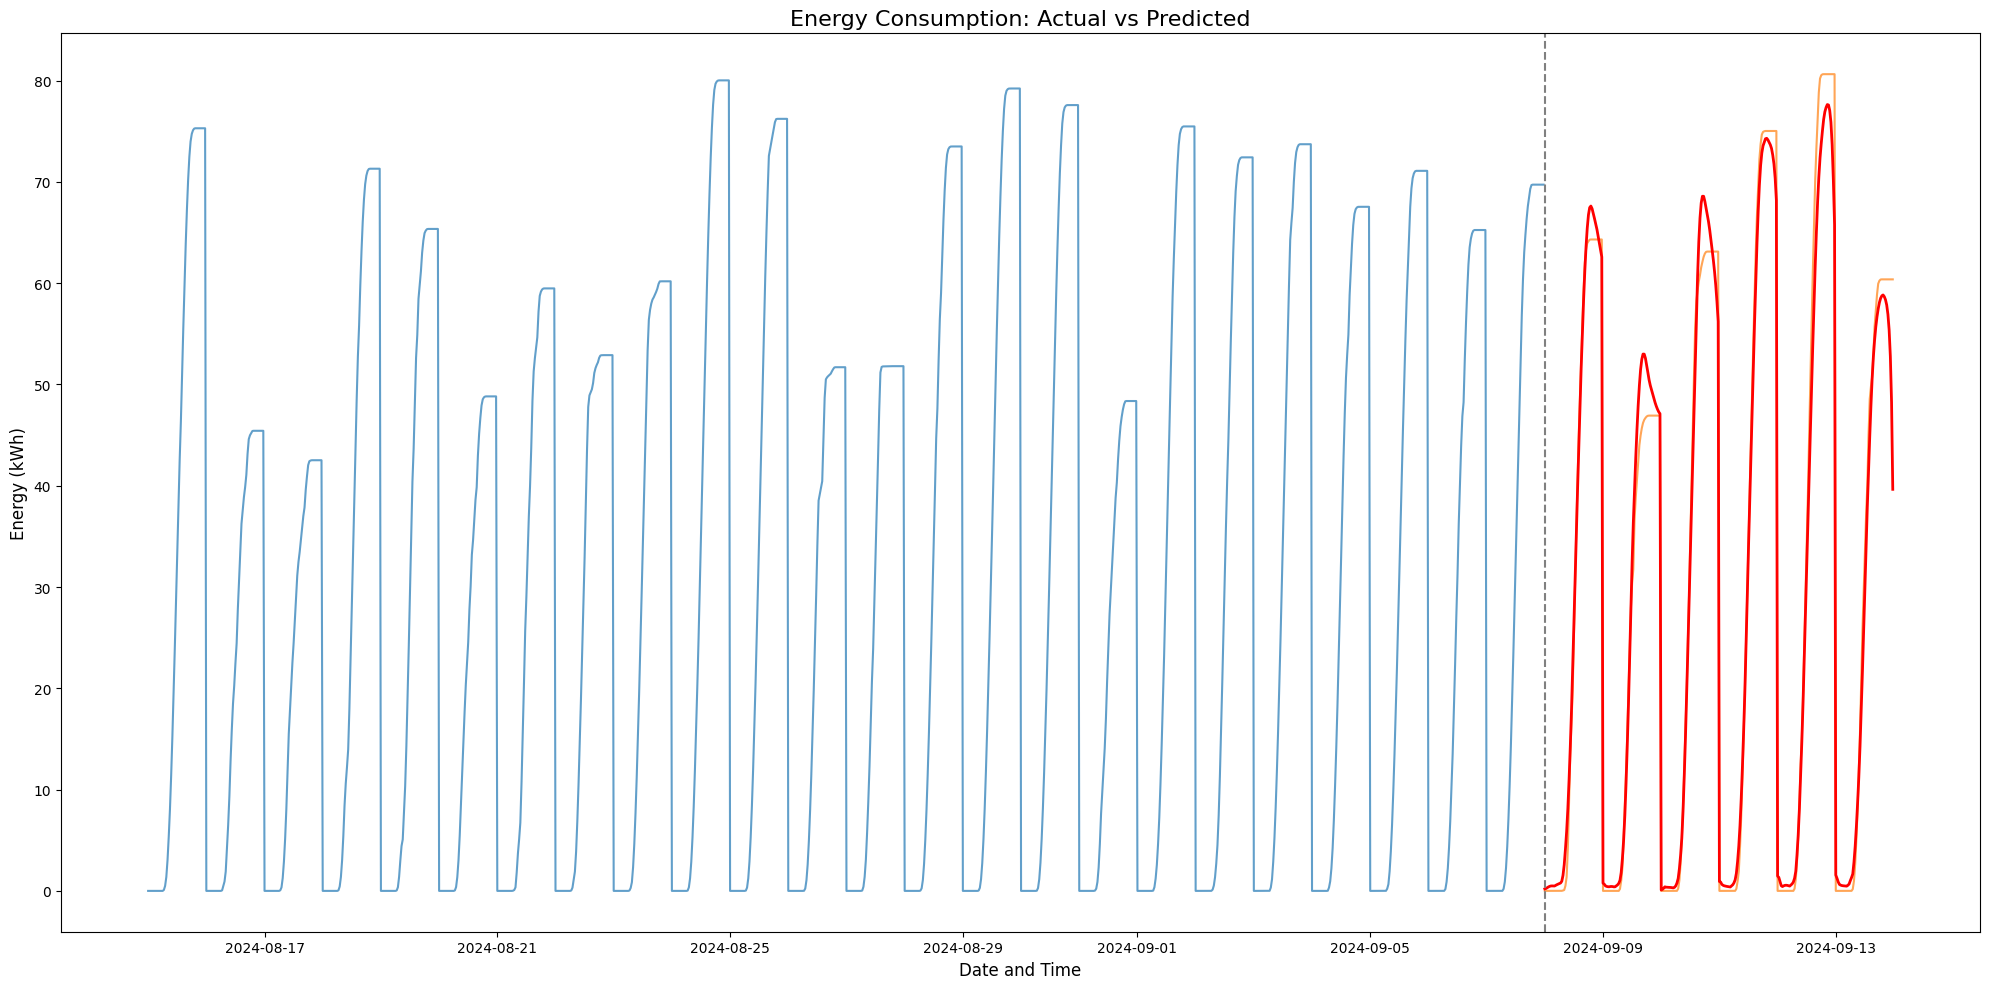

In [ ]:
plt.figure(figsize=(20, 10))

# Plot training data
plt.plot(train_index, y_train_orig, label='Training Data', alpha=0.7)

# Plot test data (actual)
plt.plot(test_index, y_test_orig, label='Test Data', alpha=0.7)

# Plot predictions
plt.plot(test_index, y_pred_original, label='Predictions', color='red', linewidth=2)

# Add vertical lines at train/test split
split_date = test_index[0]
plt.axvline(x=split_date, color='grey', linestyle='--', label='Train/Test Split')

# Add labels and title
plt.title('Energy Consumption: Actual vs Predicted', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)

plt.tight_layout()
plt.show()

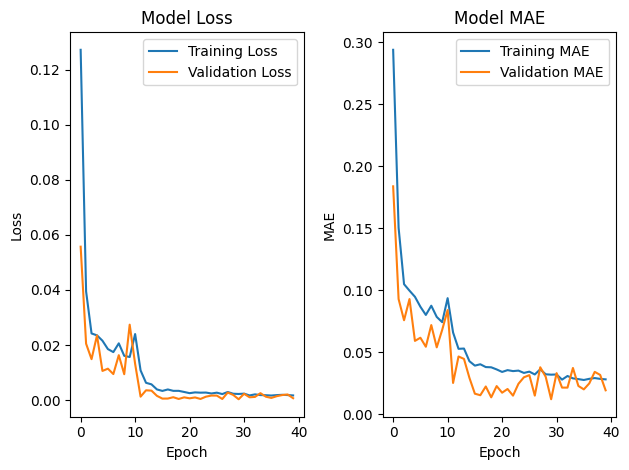

In [ ]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))


print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"Root Mean Square Error: {rmse:.2f} kWh")

Mean Absolute Error: 2.14 kWh
Root Mean Square Error: 3.27 kWh


Cheking if the model is overfitting using the loss cuvers

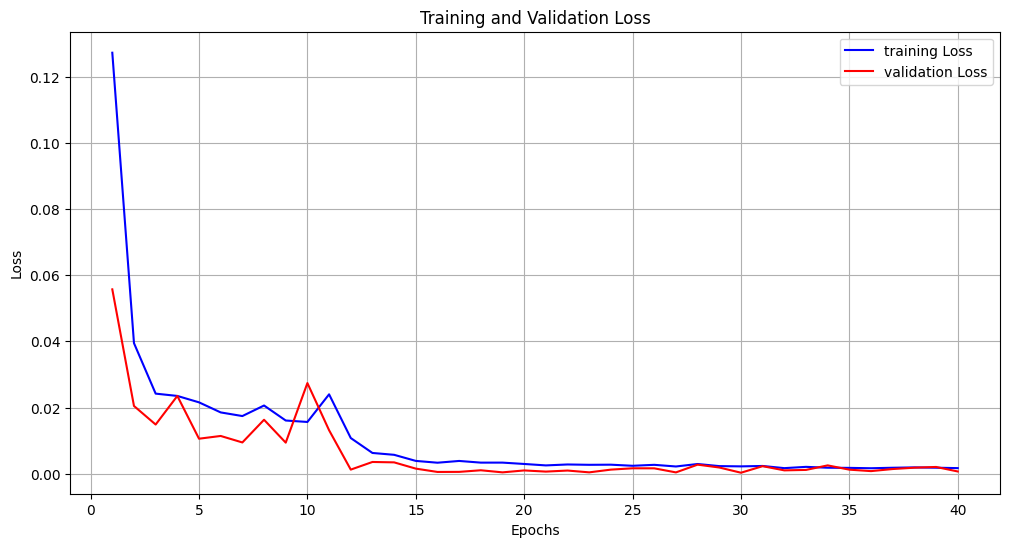

In [ ]:
def plot_loss_cuvers(history):
  train_loss = history.history['loss']
  var_loss = history.history['val_loss']

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(12, 6))
  plt.plot(epochs, train_loss, 'b', label='training Loss')
  plt.plot(epochs, var_loss, 'r', label='validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_loss_cuvers(history)